In [5]:
import pandas as pd

In [62]:
train_df = pd.read_csv('../dataset/train.csv')

In [63]:
train_df.head()

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia


In [5]:
# train과 dev 8:2로 나누기

from sklearn.model_selection import train_test_split

train_df, dev_df = train_test_split(train_df, test_size=0.2, random_state=1234)

In [6]:
train_df.shape, dev_df.shape

((25976, 6), (6494, 6))

In [9]:
# 저장하기

train_df.to_csv('./dataset/base_train.csv', index=False)
dev_df.to_csv('./dataset/base_dev.csv', index=False)

## Source가 label에 끼치는 영향 분석

In [64]:
train_df['source'].value_counts()

source
wikipedia          21620
wikitree           10672
policy_briefing      178
Name: count, dtype: int64

In [90]:
# sourece별 label 분포 확인

train_df.groupby(['source', 'label']).size().reset_index(name='count') 

,source,label,count
0,policy_briefing,no_relation,30
1,policy_briefing,org:alternate_names,6
2,policy_briefing,org:member_of,8
3,policy_briefing,org:members,1
4,policy_briefing,org:number_of_employees/members,3
...,...,...,...
64,wikitree,per:religion,2
65,wikitree,per:schools_attended,10
66,wikitree,per:siblings,14
67,wikitree,per:spouse,359


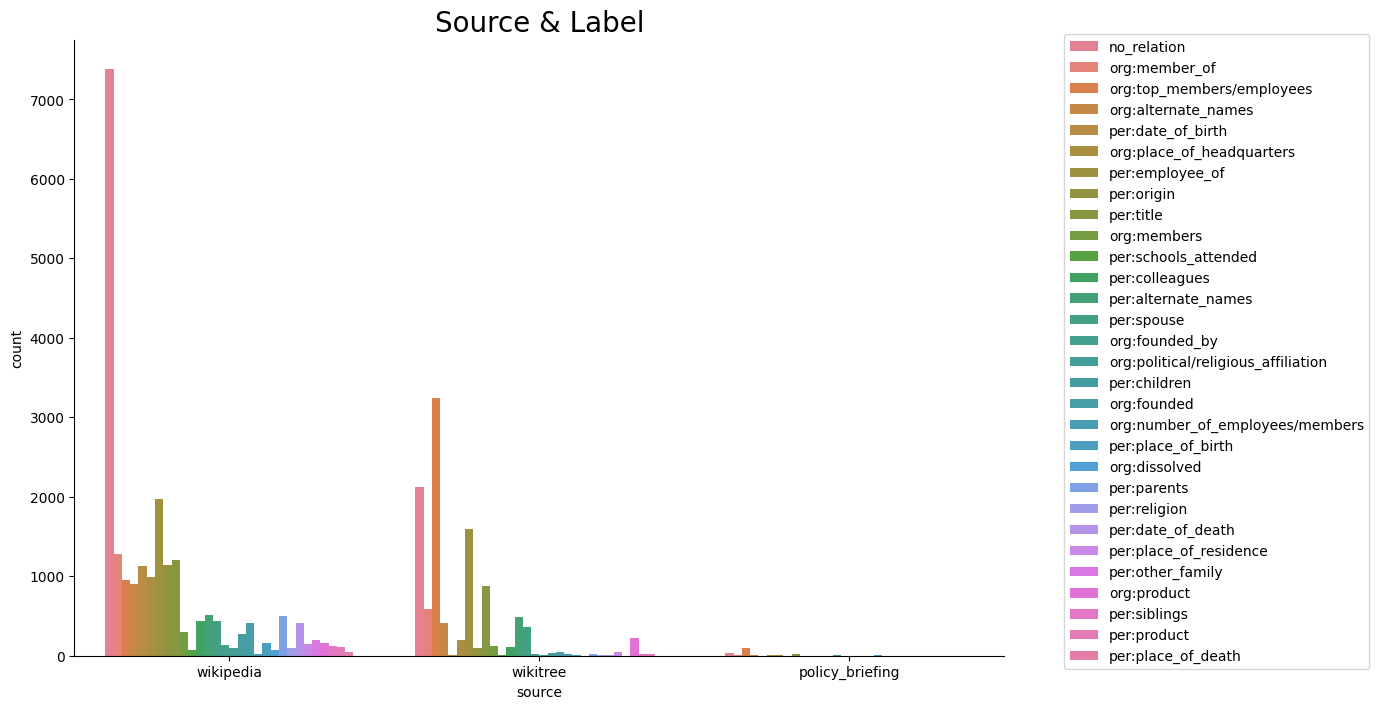

In [86]:
# source별 label 분포 시각화

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
ax = sns.countplot(data=train_df, x='source', hue='label')
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.02))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Source & Label', fontsize=20)

plt.show()

## 라벨 별 문장 길이 분석

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from transformers import AutoTokenizer

/opt/conda/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_df = pd.read_csv('../dataset/train.csv')

In [4]:
# 라벨 별 문장 길이 분석

MODEL = 'klue/roberta-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL)

train_df['length'] = train_df['sentence'].apply(lambda x: len(x))
train_df['token_length'] = train_df['sentence'].apply(lambda x: len(tokenizer.tokenize(x))) # without special tokens

In [5]:
train_df[['length','token_length']].describe()


,length,token_length
count,32470.000000,32470.000000
mean,97.083954,50.958608
std,47.939902,24.921942
min,14.000000,7.000000
25%,64.000000,34.000000
50%,87.000000,46.000000
75%,118.000000,62.000000
max,455.000000,229.000000


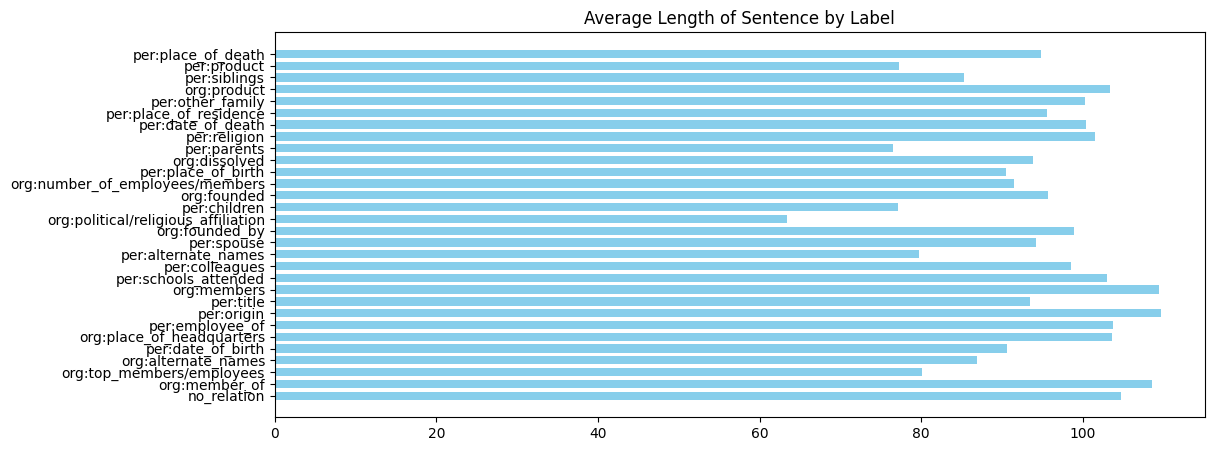

In [19]:
plt.figure(figsize=(12, 5))

plt.barh(train_df['label'].unique(), train_df.groupby('label')['length'].mean(),color='skyblue',height=0.7)
plt.title('Average Length of Sentence by Label')

plt.show()

## 중복 문장 분석 및 오류 데이터 찾기

In [37]:
# 중복 문장 분석

train_df['sentence'].describe()

count                                                 32470
unique                                                28803
top       1380년 샤를 5세가 사망한 후 샤를 6세(재위 1380년 ~ 1422년) 시대에...
freq                                                      3
Name: sentence, dtype: object

In [35]:
train_df[train_df['sentence'] == train_df['sentence'].describe().top]

,id,sentence,subject_entity,object_entity,label,source,length,token_length
6800,6800,1380년 샤를 5세가 사망한 후 샤를 6세(재위 1380년 ~ 1422년) 시대에...,"{'word': '샤를 6세', 'start_idx': 19, 'end_idx': ...","{'word': '1422년', 'start_idx': 36, 'end_idx': ...",no_relation,wikipedia,81,41
9807,9807,1380년 샤를 5세가 사망한 후 샤를 6세(재위 1380년 ~ 1422년) 시대에...,"{'word': '샤를 6세', 'start_idx': 19, 'end_idx': ...","{'word': '샤를 5세', 'start_idx': 6, 'end_idx': 1...",no_relation,wikipedia,81,41
32307,32307,1380년 샤를 5세가 사망한 후 샤를 6세(재위 1380년 ~ 1422년) 시대에...,"{'word': '샤를 5세', 'start_idx': 6, 'end_idx': 1...","{'word': '샤를 6세', 'start_idx': 19, 'end_idx': ...",no_relation,wikipedia,81,41


In [57]:
# 두번 이상 나온 문장들을 추출하고 중복 빈도에 따른 내림차순 정렬

duplicate_sentence_counts = train_df['sentence'].value_counts()
duplicate_sentences = duplicate_sentence_counts[duplicate_sentence_counts > 1].index

# 해당 문장들을 필터링하고 내림차순으로 정렬한 DataFrame 생성
result_df = train_df[train_df['sentence'].isin(duplicate_sentences)]
result_df['sentence_counts'] = result_df['sentence'].map(duplicate_sentence_counts)  # 등장 빈도 열 추가
result_df = result_df.sort_values(by=['sentence_counts', 'sentence'], ascending=[False, False]).drop(columns='sentence_counts')
result_df

/tmp/ipykernel_110155/1658675785.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['sentence_counts'] = result_df['sentence'].map(duplicate_sentence_counts)  # 등장 빈도 열 추가


,id,sentence,subject_entity,object_entity,label,source,length,token_length
9524,9524,"휘그당은 다시 윌리엄 헨리 해리슨을 대통령 후보로 지명하였고, 버지니아 주의 전 상...","{'word': '존 타일러', 'start_idx': 48, 'end_idx': ...","{'word': '휘그당', 'start_idx': 0, 'end_idx': 2, ...",per:employee_of,wikipedia,71,36
23936,23936,"휘그당은 다시 윌리엄 헨리 해리슨을 대통령 후보로 지명하였고, 버지니아 주의 전 상...","{'word': '윌리엄 헨리 해리슨', 'start_idx': 8, 'end_id...","{'word': '존 타일러', 'start_idx': 48, 'end_idx': ...",per:colleagues,wikipedia,71,36
30438,30438,"휘그당은 다시 윌리엄 헨리 해리슨을 대통령 후보로 지명하였고, 버지니아 주의 전 상...","{'word': '윌리엄 헨리 해리슨', 'start_idx': 8, 'end_id...","{'word': '휘그당', 'start_idx': 0, 'end_idx': 2, ...",per:employee_of,wikipedia,71,36
22741,22741,"홍무제의 손자이며, 영락제와 인효문황후 서씨(仁孝文皇后 徐氏)의 장남이다.","{'word': '영락제', 'start_idx': 11, 'end_idx': 13...","{'word': '홍무제', 'start_idx': 0, 'end_idx': 2, ...",per:parents,wikipedia,41,30
24087,24087,"홍무제의 손자이며, 영락제와 인효문황후 서씨(仁孝文皇后 徐氏)의 장남이다.","{'word': '영락제', 'start_idx': 11, 'end_idx': 13...","{'word': '인효문황후', 'start_idx': 16, 'end_idx': ...",per:spouse,wikipedia,41,30
...,...,...,...,...,...,...,...,...
32434,32434,"""탕약망""이란 예수회 선교사 천문학자 아담 샬의 중국 이름이다.","{'word': '아담 샬', 'start_idx': 21, 'end_idx': 2...","{'word': '예수회', 'start_idx': 8, 'end_idx': 10,...",per:employee_of,wikipedia,35,17
3588,3588,"""소이현, 인교진이 하는 광고는 괜찮고"", ""차 광고할 때 여자가 남자한테 하던 소...","{'word': '인교진', 'start_idx': 6, 'end_idx': 8, ...","{'word': '소이현', 'start_idx': 52, 'end_idx': 54...",no_relation,wikitree,85,49
28051,28051,"""소이현, 인교진이 하는 광고는 괜찮고"", ""차 광고할 때 여자가 남자한테 하던 소...","{'word': '소이현', 'start_idx': 52, 'end_idx': 54...","{'word': '인교진', 'start_idx': 6, 'end_idx': 8, ...",no_relation,wikitree,85,49
919,919,"""2006년 지방선거에 참패하고 민주당과 그 전신인 열린 우리당은 노 씨의 국정 운...","{'word': '열린 우리당', 'start_idx': 29, 'end_idx':...","{'word': '노무현', 'start_idx': 127, 'end_idx': 1...",no_relation,wikipedia,234,115


In [60]:
# sentence, subject, object entity가 같지만, label이 다른 이상한 데이터를 찾기 위해 
# 먼저, sentence, subject, object entity가 같은 데이터 찾기
sentnece_sb_ob_equal = result_df[result_df.duplicated(subset=['sentence','subject_entity', 'object_entity'], keep=False)]
sentnece_sb_ob_equal

,id,sentence,subject_entity,object_entity,label,source,length,token_length
277,277,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",no_relation,wikitree,101,50
3296,3296,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",per:title,wikitree,101,50
10202,10202,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",no_relation,wikitree,101,50
17142,17142,"이 책은 천정배 의원의 유년기와 전남 신안 암태 동초등학교, 목포중·고등학교 시절 ...","{'word': '새정치국민회의', 'start_idx': 110, 'end_idx...","{'word': '김대중', 'start_idx': 103, 'end_idx': 1...",org:top_members/employees,wikitree,330,169
31038,31038,"이 책은 천정배 의원의 유년기와 전남 신안 암태 동초등학교, 목포중·고등학교 시절 ...","{'word': '새정치국민회의', 'start_idx': 110, 'end_idx...","{'word': '김대중', 'start_idx': 103, 'end_idx': 1...",org:top_members/employees,wikitree,330,169
...,...,...,...,...,...,...,...,...
3547,3547,2010년 10월 15일 전라북도청을 방문한 맹형규 행정안전부 장관은 도내 지자체간...,"{'word': '전라북도청', 'start_idx': 14, 'end_idx': ...","{'word': '행정안전부', 'start_idx': 29, 'end_idx': ...",no_relation,wikipedia,234,117
2500,2500,2001년 4월 민주국민당 김윤환 의원과 민주당 의원 사이의 정책 연합과 관련한 통...,"{'word': '민주국민당', 'start_idx': 9, 'end_idx': 1...","{'word': '민주당', 'start_idx': 23, 'end_idx': 25...",no_relation,wikipedia,58,29
25368,25368,2001년 4월 민주국민당 김윤환 의원과 민주당 의원 사이의 정책 연합과 관련한 통...,"{'word': '민주국민당', 'start_idx': 9, 'end_idx': 1...","{'word': '민주당', 'start_idx': 23, 'end_idx': 25...",no_relation,wikipedia,58,29
9618,9618,"1959-60 시즌 이후의 알파 에트니키 / 수페르리가 엘라다, 그리스 컵, 그리고...","{'word': '수페르리가 엘라다', 'start_idx': 25, 'end_id...","{'word': '그리스', 'start_idx': 36, 'end_idx': 38...",no_relation,wikipedia,57,28


In [56]:
grouped = sentnece_sb_ob_equal.groupby(['sentence', 'subject_entity', 'object_entity'])['label'].nunique()

# 두 개 이상의 서로 다른 label이 있는 그룹만 추출
result_groups = grouped[grouped > 1].index

# 해당 그룹들을 필터링한 DataFrame 생성
result_df = sentnece_sb_ob_equal[sentnece_sb_ob_equal.set_index(['sentence', 'subject_entity', 'object_entity']).index.isin(result_groups)]
result_df

,id,sentence,subject_entity,object_entity,label,source,length,token_length
277,277,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",no_relation,wikitree,101,50
3296,3296,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",per:title,wikitree,101,50
10202,10202,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",no_relation,wikitree,101,50
6749,6749,대한항공은 5일 조양호 회장의 3자녀가 보유한 싸이버스카이 주식 9만9900주 전량...,"{'word': '대한항공', 'start_idx': 0, 'end_idx': 3,...","{'word': '조양호', 'start_idx': 9, 'end_idx': 11,...",no_relation,wikipedia,65,34
12829,12829,대한항공은 5일 조양호 회장의 3자녀가 보유한 싸이버스카이 주식 9만9900주 전량...,"{'word': '대한항공', 'start_idx': 0, 'end_idx': 3,...","{'word': '조양호', 'start_idx': 9, 'end_idx': 11,...",org:top_members/employees,wikipedia,65,34
4212,4212,한편 전라남도는 최근 확진자가 발생한 순천시와 여수시에 마스크를 각각 2만장씩 총 ...,"{'word': '전라남도', 'start_idx': 3, 'end_idx': 6,...","{'word': '여수시', 'start_idx': 26, 'end_idx': 28...",org:members,wikitree,99,48
25094,25094,한편 전라남도는 최근 확진자가 발생한 순천시와 여수시에 마스크를 각각 2만장씩 총 ...,"{'word': '전라남도', 'start_idx': 3, 'end_idx': 6,...","{'word': '여수시', 'start_idx': 26, 'end_idx': 28...",org:place_of_headquarters,wikitree,99,48
11511,11511,"영화 '버즈 오브 프레이'는 배트맨이 없는 고담시에서 할리퀸, 헌트리스, 블랙 카나...","{'word': '배트맨', 'start_idx': 16, 'end_idx': 18...","{'word': '고담시', 'start_idx': 24, 'end_idx': 26...",per:place_of_residence,wikitree,71,39
22258,22258,"영화 '버즈 오브 프레이'는 배트맨이 없는 고담시에서 할리퀸, 헌트리스, 블랙 카나...","{'word': '배트맨', 'start_idx': 16, 'end_idx': 18...","{'word': '고담시', 'start_idx': 24, 'end_idx': 26...",no_relation,wikitree,71,39
8364,8364,배우 김병철 씨가 연기하는 정복동은 천리마마트를 망하게 하기 위해 여러 계획을 세우...,"{'word': '정복동', 'start_idx': 15, 'end_idx': 17...","{'word': '김병철', 'start_idx': 3, 'end_idx': 5, ...",no_relation,wikitree,73,37


## 한자 등장 빈도 분석

In [101]:
def find_chinese_characters(sentence):
    chinese_characters = [char for char in sentence if '\u4e00' <= char <= '\u9fff']
    return chinese_characters

train_df = train_df.copy()
train_df['chineese_character'] = train_df['sentence'].apply(find_chinese_characters)

train_df['has_chinese'] = train_df['sentence'].str.contains('[\u4e00-\u9fff]')

chinese_samples = train_df[train_df['has_chinese']]
chinese_samples

,id,sentence,subject_entity,object_entity,label,source,chineese_character,has_chinese
7,7,"박용오(朴容旿, 1937년 4월 29일(음력 3월 19일)(음력 3월 19일) ~ ...","{'word': '박용오', 'start_idx': 0, 'end_idx': 2, ...","{'word': '1937년 4월 29일', 'start_idx': 9, 'end_...",per:date_of_birth,wikipedia,"[朴, 容, 旿]",True
62,62,"김동성(金東聖, 1980년 2월 9일 ~)은 대한민국의 쇼트트랙 선수이다.","{'word': '김동성', 'start_idx': 0, 'end_idx': 2, ...","{'word': '1980년 2월 9일', 'start_idx': 9, 'end_i...",per:date_of_birth,wikipedia,"[金, 東, 聖]",True
69,69,칸트는 미(美)란 숭고함이다라고 주장하였는데 그의 이러한 주장은 윌리엄 터너(Jos...,"{'word': '윌리엄 터너', 'start_idx': 36, 'end_idx':...","{'word': '낭만주의', 'start_idx': 78, 'end_idx': 8...",no_relation,wikipedia,[美],True
83,83,진도군은 진도개를 보기 위해 찾아온 관람객들에게 더욱 흥미롭고 즐거움을 선사하기 위...,"{'word': '진도군', 'start_idx': 0, 'end_idx': 2, ...","{'word': '진도개', 'start_idx': 5, 'end_idx': 7, ...",no_relation,wikitree,[犬],True
91,91,"백한성(白漢成, 水原鶴人, 1899년 6월 15일 조선 충청도 공주 출생 ~ 197...","{'word': '백한성', 'start_idx': 0, 'end_idx': 2, ...","{'word': '조선 충청도 공주', 'start_idx': 28, 'end_id...",per:place_of_birth,wikipedia,"[白, 漢, 成, 水, 原, 鶴, 人]",True
...,...,...,...,...,...,...,...,...
32402,32402,"1990년 국가보훈처에 의해 이상룡(李相龍), 이승화(李承和), 이광민(李光民) 등...","{'word': '이광민', 'start_idx': 36, 'end_idx': 38...","{'word': '독립운동가', 'start_idx': 49, 'end_idx': ...",per:title,wikipedia,"[李, 相, 龍, 李, 承, 和, 李, 光, 民]",True
32411,32411,"가톨릭평화방송(가톨릭平和放送, Catholic Peace Broadcasting C...","{'word': '가톨릭평화방송', 'start_idx': 0, 'end_idx':...","{'word': '가톨릭平和放送', 'start_idx': 8, 'end_idx':...",org:alternate_names,wikipedia,"[平, 和, 放, 送]",True
32438,32438,"간 나오토는 총리 취임에 즈음해 당 간사장에 에다노 유키오, 내각관방장관에 센고쿠 ...","{'word': '에다노 유키오', 'start_idx': 25, 'end_idx'...","{'word': '센고쿠 요시토', 'start_idx': 42, 'end_idx'...",no_relation,wikipedia,[非],True
32449,32449,"이때 만주 지역에는 크고작은 독립군이 조직되었고, 동만주지방의 홍범도가 이끄는 대한...","{'word': '홍범도', 'start_idx': 35, 'end_idx': 37...","{'word': '대한독립군', 'start_idx': 44, 'end_idx': ...",per:employee_of,wikipedia,"[安, 武, 崔, 振, 東]",True
